# Import libraries and dataset

In [ ]:
!pip install split-folders
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-sz9w9knl
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-sz9w9knl
  Resolved https://github.com/tensorflow/docs to commit 60abeb06e500fa5edbbac374fc0d8142c8322aef
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.10.27.81990-py3-none-any.whl size=184142 sha256=ebb5b2c0d0c290e9943daf084b4902d8a5daa81926407b2659208b0c8fffee75
  Stored in directory: /tmp/pip-ephem-wheel-cache-hsvk6lqo/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [ ]:
# import requirement libraries and tools
import os
import pathlib
import itertools
import splitfolders
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# To enable dynamic memory allocation, run the following commands
# at the start of the session :
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (551).jpg  
  inflating: Rice_Image_Dataset/Karacadag/Karacadag (5510).jpg  
  inflating: Rice_Image_Dataset/Karacadag/K

In [ ]:
root_path = '/content/Rice_Image_Dataset'
root_path = pathlib.Path(root_path)

# Prepare and validate dataset



In [ ]:
splitfolders.ratio(input=root_path, output='rice_imgs', seed=42, ratio=(0.7, 0.15, 0.15))

Copying files: 75000 files [00:19, 3863.71 files/s]


In [ ]:
BATCH_SIZE = 16
# resize the images from the directories to prevent ResourceExhaustedError
IMAGE_SIZE = (150, 150)

Train = keras.utils.image_dataset_from_directory(
    directory='/content/rice_imgs/train',
    labels='inferred',
    label_mode='int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed=42,
)

Validation = keras.utils.image_dataset_from_directory(
    directory='/content/rice_imgs/val',
    labels='inferred',
    label_mode='int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed=42,
)

Test = keras.utils.image_dataset_from_directory(
    directory='/content/rice_imgs/test',
    labels='inferred',
    label_mode='int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed=42,
)

Found 52500 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.
Found 11250 files belonging to 5 classes.


In [ ]:
# check class in each set
for i in [Train, Validation, Test]:
    class_names = i.class_names
    print(class_names)

['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


In [ ]:
# check shape of train, validation, test
for image_batch, labels_batch in Train:
    print(f"Train Shape: {image_batch.shape} (Bathes = {len(Train)})")
    print(f"Train label: {labels_batch.shape}\n")
    break
for image_batch, labels_batch in Validation:
    print(f"Validation Shape: {image_batch.shape} (Bathes = {len(Validation)})")
    print(f"Validation label: {labels_batch.shape}\n")
    break
for image_batch, labels_batch in Test:
    print(f"Test Shape: {image_batch.shape} (Bathes = {len(Test)})")
    print(f"Test label: {labels_batch.shape}\n")
    break

Train Shape: (16, 150, 150, 3) (Bathes = 3282)
Train label: (16,)

Validation Shape: (16, 150, 150, 3) (Bathes = 704)
Validation label: (16,)

Test Shape: (16, 150, 150, 3) (Bathes = 704)
Test label: (16,)



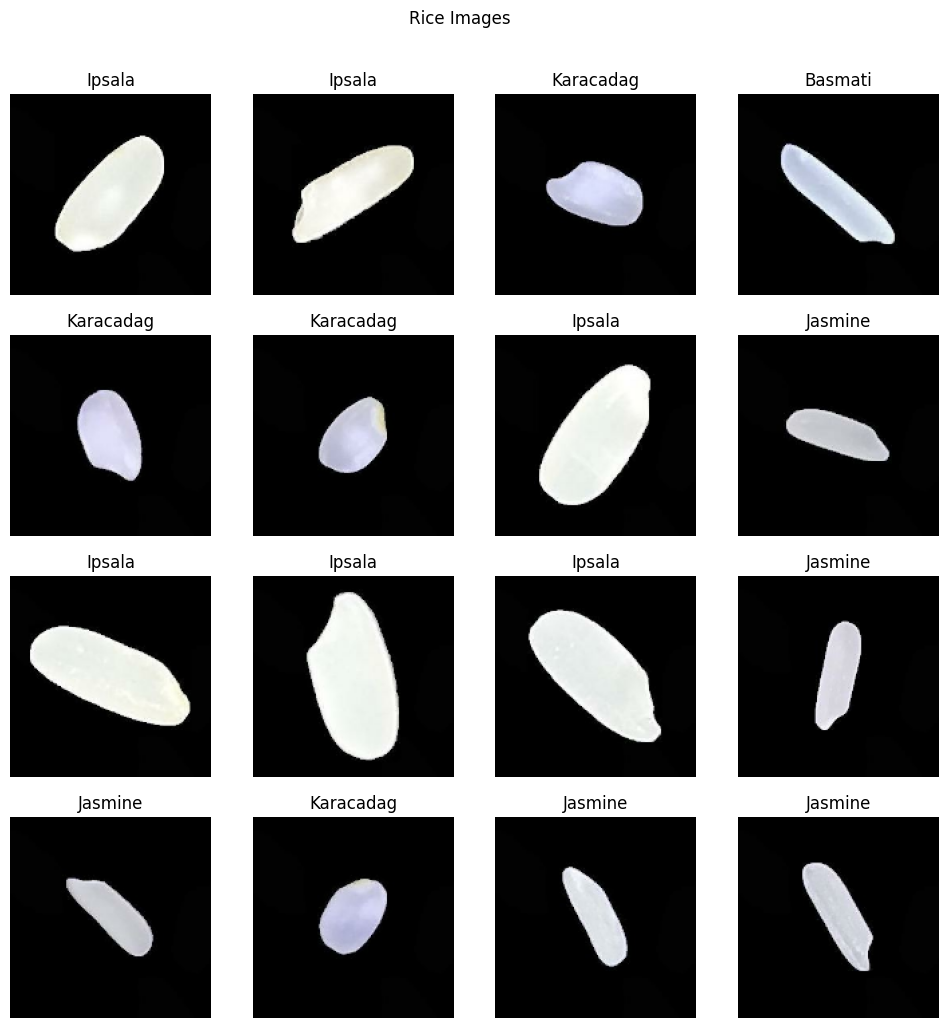

In [ ]:
# visualize the data to verify is in the correct format
plt.figure(figsize=(12, 12))
for images, labels in Train.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    plt.suptitle('Rice Images', y=0.95)
plt.show()

# Model 1

In [ ]:
# Build CNN first Model: 1 conv layer | 1 pool layer | 2 Dense layer | ReLU activation
model_1 = tf.keras.Sequential(
    [
        tf.keras.layers.Rescaling(1./255, input_shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(filters=2, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=10, strides=10),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=20, activation='relu'),
        tf.keras.layers.Dense(units=5),
    ]
)

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 149, 149, 2)       26        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 2)         0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense (Dense)               (None, 20)                7860      
                                                                 
 dense_1 (Dense)             (None, 5)                 105       
                                                        

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam

def compile_and_fit(model, optimizer=None, max_epochs=2):
    """
    Compile model and fit model on dataset based on input model until find best epoch
        model: created model
        optimizer: defined optimizer
        max_epochs: Number of epochs
    """

    if optimizer is None:
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    # complie model before train
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # train model
    history = model.fit(
        Train,
        epochs=max_epochs,
        validation_data=Validation,
        callbacks=tf.keras.callbacks.EarlyStopping(monitor='val_loss' , patience=8),
    )

    return history

In [ ]:
# train model_1 and store results
model_hist = compile_and_fit(model_1, max_epochs=6)

Epoch 1/6
3282/3282 [==============================] - 369s 112ms/step - loss: 0.2063 - accuracy: 0.9314 - val_loss: 0.1223 - val_accuracy: 0.9604
Epoch 2/6
3282/3282 [==============================] - 363s 110ms/step - loss: 0.1230 - accuracy: 0.9585 - val_loss: 0.1094 - val_accuracy: 0.9626
Epoch 3/6
3282/3282 [==============================] - 360s 110ms/step - loss: 0.1078 - accuracy: 0.9630 - val_loss: 0.0895 - val_accuracy: 0.9709
Epoch 4/6
3282/3282 [==============================] - 355s 108ms/step - loss: 0.0955 - accuracy: 0.9673 - val_loss: 0.0782 - val_accuracy: 0.9744
Epoch 5/6
3282/3282 [==============================] - 359s 109ms/step - loss: 0.0851 - accuracy: 0.9713 - val_loss: 0.0836 - val_accuracy: 0.9703
Epoch 6/6
3282/3282 [==============================] - 336s 102ms/step - loss: 0.0748 - accuracy: 0.9751 - val_loss: 0.0798 - val_accuracy: 0.9714


In [ ]:
def plot_comparision_result(model):
    """
    Plot diagram of accuracy and loss for train and validation set
        model: created model
    """

    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Plot train and validation accuracy
    axs[0].plot(model.history['accuracy'], color="red", marker="o")
    axs[0].plot(model.history['val_accuracy'], color="blue", marker="h")
    axs[0].set_title('Accuracy Comparison between Train & Validation Set')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Train', 'Validation'], loc="lower right")

    # Plot train and validation loss
    axs[1].plot(model.history['loss'], color="red", marker="o")
    axs[1].plot(model.history['val_loss'], color="blue", marker="h")
    axs[1].set_title('Loss Comparison between Train & Validation Set')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Train', 'Validation'], loc="upper right")

    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
        cm(array): confusion matrix
        classes(dictionary): classes of our target (key=categorical type, value=numerical type)
    """
    plt.figure(figsize=(10,7))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------

def get_ture_and_pred_labels(dataset, model):
    """
    Get out 2 list include y_true and y_pred for use in confusion_matrix
        dataset: dataset include images and label
        model: created model
    """

    y_true = []
    y_pred = []

    for images, labels in dataset:
        labels = labels.numpy()
        outputs = tf.nn.softmax(model(images))
        pred = tf.argmax(outputs, axis=1).numpy()
        images = images.numpy()

        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)

    return y_true, y_pred

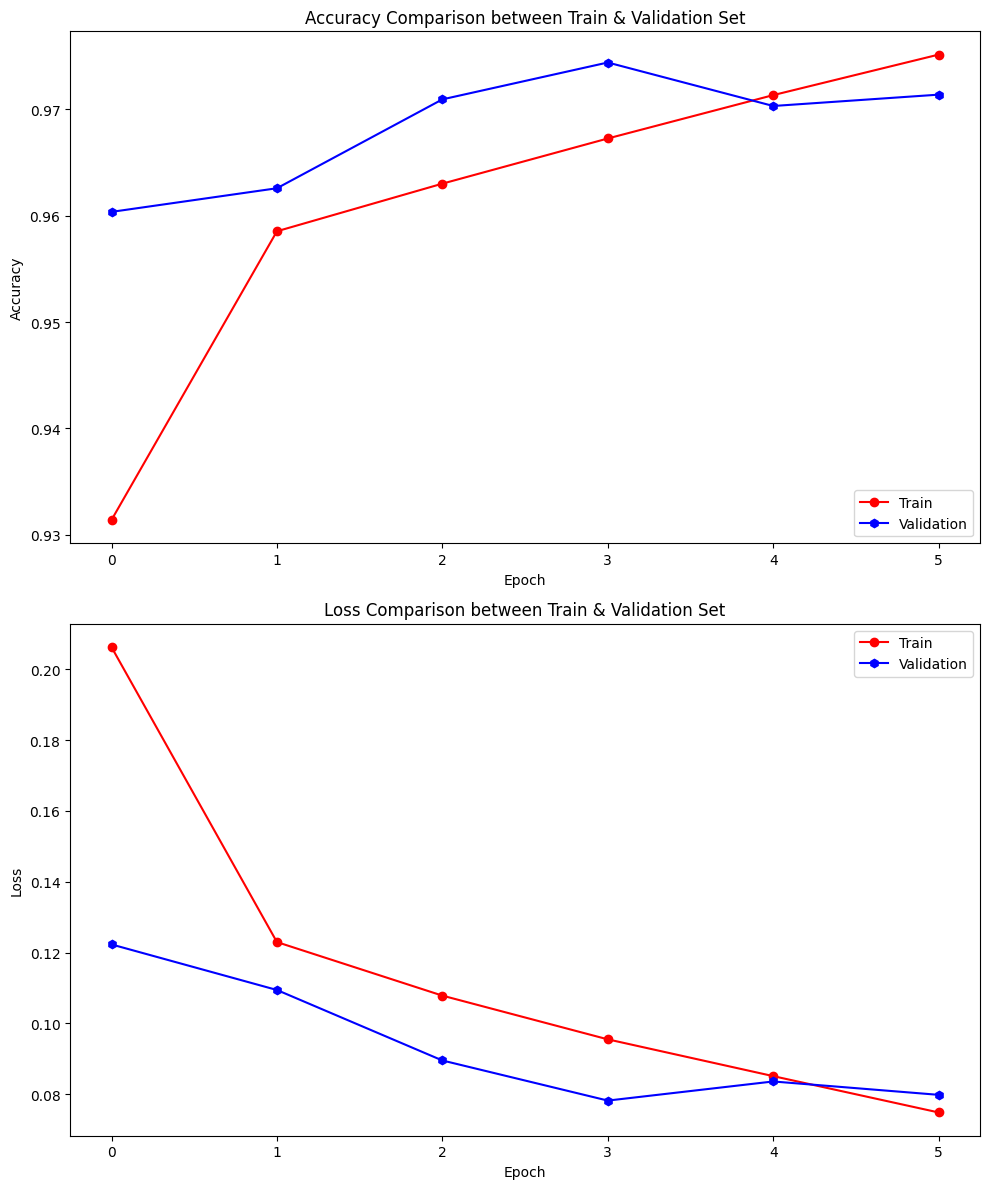

In [ ]:
plot_comparision_result(model_hist)

              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96      2250
         1.0       0.95      0.99      0.97      2250
         2.0       0.99      1.00      0.99      2250
         3.0       0.99      0.93      0.96      2250
         4.0       0.95      0.99      0.97      2250

    accuracy                           0.97     11250
   macro avg       0.97      0.97      0.97     11250
weighted avg       0.97      0.97      0.97     11250
 




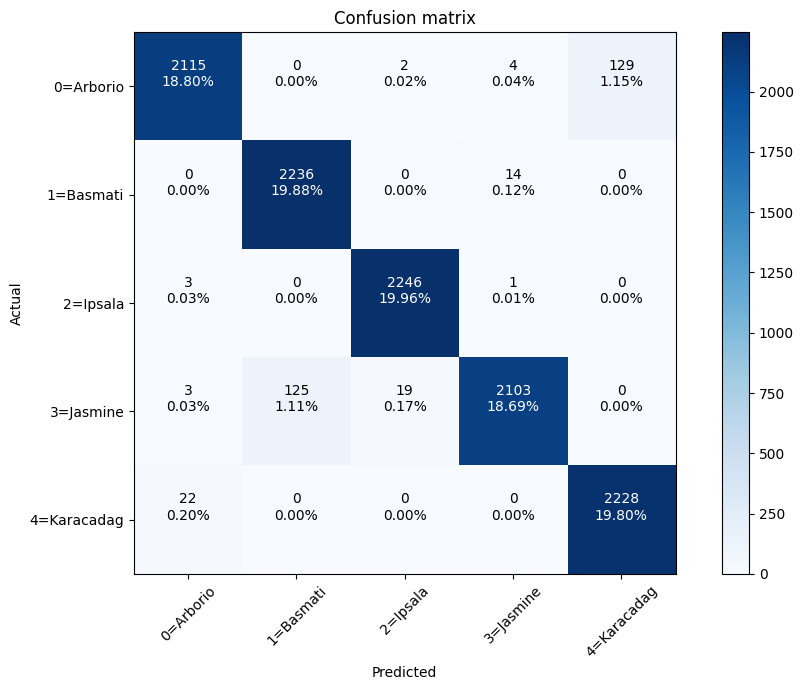

In [ ]:
y_true_val, y_pred_val = get_ture_and_pred_labels(Validation, model_1)

print(classification_report(y_true_val, y_pred_val), '\n\n')
cm = confusion_matrix(y_true_val, y_pred_val)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [ ]:
model_1.save('model_1')

In [ ]:
# Evaluate Finanl model and check it
test_loss, test_acc = model_1.evaluate(Test, verbose=2)
print(f'\nTest accuracy:{test_acc} (test_loss: {test_loss})')

704/704 - 35s - loss: 0.0836 - accuracy: 0.9690 - 35s/epoch - 49ms/step

Test accuracy:0.9689777493476868 (test_loss: 0.08358241617679596)


              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      2250
         1.0       0.96      0.99      0.97      2250
         2.0       0.98      1.00      0.99      2250
         3.0       0.99      0.93      0.96      2250
         4.0       0.94      0.99      0.96      2250

    accuracy                           0.97     11250
   macro avg       0.97      0.97      0.97     11250
weighted avg       0.97      0.97      0.97     11250
 




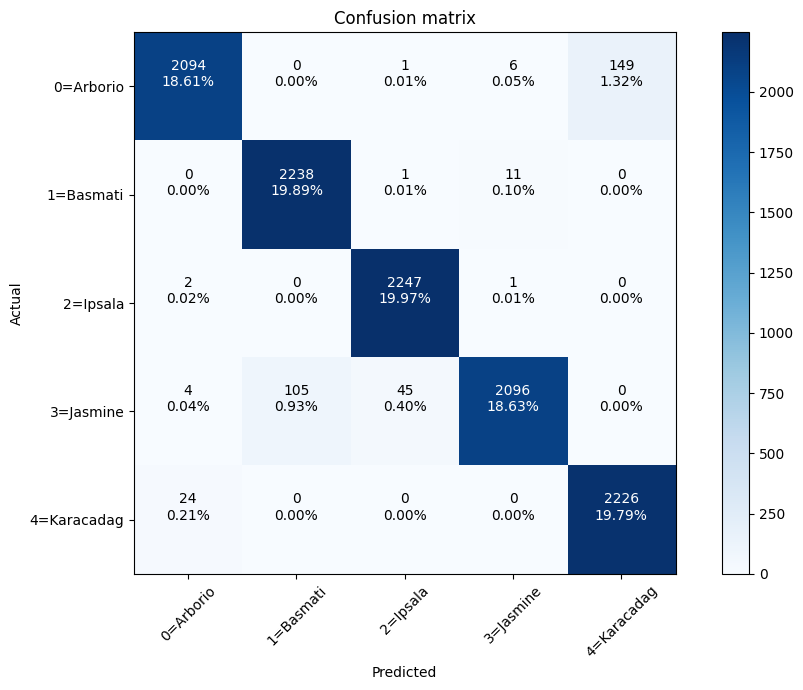

In [ ]:
y_true_test, y_pred_test = get_ture_and_pred_labels(Test, model_1)

print(classification_report(y_true_test, y_pred_test), '\n\n')
cm = confusion_matrix(y_true_test, y_pred_test)

classes = {
    "Arborio":0,
    "Basmati":1,
    "Ipsala":2,
    "Jasmine":3,
    "Karacadag":4,
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)